In [ ]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant import xtdata
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [79]:

file_dx = 'D:\workspace\TradeX\ezMoney\database\低吸_2025-01-27.csv'
file_jl = 'D:\workspace\TradeX\ezMoney\database\接力_2025-01-27.csv'
file_zz = 'D:\workspace\TradeX\ezMoney\database\追涨_2025-01-27.csv'
files = [file_dx, file_jl, file_zz]

strategies = {}
for file in files:
    df = pd.read_csv(file)
    unique_values = df['sub_strategy_name'].unique().tolist()
    unique_key = df['strategy_name'].unique().tolist()
    strategies[unique_key[0]] = unique_values

def calculate_annualized_return(total_return, total_days):
    import math
    return math.pow(1 + total_return / total_days, 365) - 1

def caculate_returns(returns_df, row, _print = False):
    r = {}
    filter_df = returns_df[returns_df['codes_num'] > 0]
    if len(filter_df) <= 0:
        return r
    cumulative_returns = (1 + filter_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (filter_df[row].mean() - risk_free_rate) / filter_df[row].std()

    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = filter_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 365

    r['最大回撤'] =  max_drawdown
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r
   


In [3]:
from datetime import datetime

file_m = {
    '低吸': file_dx,
    '接力': file_jl,
    '追涨': file_zz
}

period_target = {
    '回测周期': ['7d', '15d', '51m1', '412m1', '411m1', '410m1', '49m1', '48m1', '51m', '412m', '411m', '410m', '49m', '48m'],
    '回测目标': ['l1', 'l2', 'l3', 'avg', 'pl1', 'pl2', 'pl3', 'pavg']
}
current_date = datetime.now()
def get_df_by_period(period, sdf, strategy, sub_strategy):
    df = sdf[(sdf['strategy_name'] == strategy) & (sdf['sub_strategy_name'] == sub_strategy)]
    if '7d' == period:
        return df[df['date'] >= current_date - pd.Timedelta(days=7)]    
    elif '15d' == period:
        return df[df['date'] >= current_date - pd.Timedelta(days=15)]
    elif '51m1' == period:
        start_date = pd.to_datetime('2025-01-01')
        return df[df['date'] >= start_date]
    elif '412m1' == period:
        start_date = pd.to_datetime('2024-12-01')
        return df[df['date'] >= start_date]
    elif '411m1' == period:
        start_date = pd.to_datetime('2024-11-01')
        return df[df['date'] >= start_date]
    elif '410m1' == period:
        start_date = pd.to_datetime('2024-10-01')
        return df[df['date'] >= start_date]
    elif '49m1' == period:
        start_date = pd.to_datetime('2024-09-01')
        return df[df['date'] >= start_date]
    elif '48m1' == period:
        start_date = pd.to_datetime('2024-08-01')
        return df[df['date'] >= start_date]
    elif '51m' == period:
        start_date = pd.to_datetime('2025-01-01')
        end_date = pd.to_datetime('2025-01-31')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    elif '412m' == period:
        start_date = pd.to_datetime('2024-12-01')
        end_date = pd.to_datetime('2024-12-31')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    elif '411m' == period:
        start_date = pd.to_datetime('2024-11-01')
        end_date = pd.to_datetime('2024-11-30')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    elif '410m' == period:
        start_date = pd.to_datetime('2024-10-01')
        end_date = pd.to_datetime('2024-10-31')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    elif '49m' == period:
        start_date = pd.to_datetime('2024-09-01')
        end_date = pd.to_datetime('2024-09-30')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    elif '48m' == period:
        start_date = pd.to_datetime('2024-08-01')
        end_date = pd.to_datetime('2024-08-31')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    else:
        return df

target_row = {
    'l1': 'first_return',
    'l2': 'top2_return',
    'l3': 'top3_return',
    'avg': 'return',
    'pl1': 'p_first_return',
    'pl2': 'p_top2_return',
    'pl3': 'p_top3_return',
    'pavg': 'p_return'
}


columns = {
    '交易名称': 'string',
    '子交易名称': 'string',
    '回测周期': 'string',
    '回测目标': 'string',
    '最大回撤': 'double',
    '夏普比率': 'double',
    '年化收益率': 'double',
    '总收益率': 'double',
    '波动率': 'double',
    '总盈亏': 'double',
    '成功次数': 'int64',
    '失败次数': 'int64',
    '胜率': 'double',
    '总天数': 'int64',
    '总交易次数': 'int64',
    '交易频率': 'double',
    '平均盈利': 'double',
    '平均亏损': 'double',
    '最大盈利': 'double',
    '最大亏损': 'double',
    '盈亏比': 'double',
    '凯利公式最佳仓位': 'double'
}

eval_df = pd.DataFrame(columns=columns.keys()).astype(columns)

for strategy, sub_strategies in strategies.items():
    file = file_m[strategy]
    df = pd.read_csv(file, dtype={'code': 'string'})
    df['date']  = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    df['p_first_return'] = df['first_return'] * df['position']
    df['p_top2_return'] = df['top2_return'] * df['position']
    df['p_top3_return'] = df['top3_return'] * df['position']
    df['p_return'] = df['return'] * df['position']
    
    for sub_strategy in sub_strategies:
        for period in period_target['回测周期']:
            print(f"开始评估..., 策略-{strategy} 子策略-{sub_strategy} 日期-{period}")
            ndf = get_df_by_period(period, df, strategy, sub_strategy)
            for target in period_target['回测目标']:
                dt = caculate_returns(ndf, target_row[target])
                if not dt or len(dt) == 0:
                    print(f"策略-{strategy} 子策略-{sub_strategy} 日期-{period} 目标-{target} 结果为空")
                    continue
                dt['交易名称'] = strategy
                dt['子交易名称'] = sub_strategy
                dt['回测周期'] = period
                dt['回测目标'] = target
                cdf = pd.DataFrame([dt])
                eval_df = pd.concat([eval_df, cdf], ignore_index=True)

eval_df.to_csv(r'D:\workspace\TradeX\ezMoney\database\eval_results\eval_0127.csv')

开始评估..., 策略-低吸 子策略-绿盘低吸 日期-7d
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-15d
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-51m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-412m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-411m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-410m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-49m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-48m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-51m
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-412m
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-411m
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-410m
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-49m
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-48m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-7d
开始评估..., 策略-低吸 子策略-首红断低吸 日期-15d
开始评估..., 策略-低吸 子策略-首红断低吸 日期-51m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-412m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-411m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-410m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-49m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-48m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-51m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-412m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-411m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-410m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-49m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-48m
开始评估..., 策略-低吸 子策略-红断低吸 日期-7d
开始评估..., 策略-低吸 子策略-红断低吸 日期-15d
开始评估..., 策略-低吸 子策略-红断低吸 日期-51m1
开始评

In [30]:
df = pd.read_csv(r'D:\workspace\TradeX\ezMoney\database\eval_results\eval_0127.csv')

In [44]:
x = df[(df['总交易次数'] > 8) & (df['回测周期'] == '51m1')].sort_values(by='胜率', ascending=False)
x[(x['胜率'] > 0.5) & (x['总收益率'] > 0.1)]

,Unnamed: 0,交易名称,子交易名称,回测周期,回测目标,最大回撤,夏普比率,年化收益率,总收益率,波动率,...,胜率,总天数,总交易次数,交易频率,平均盈利,平均亏损,最大盈利,最大亏损,盈亏比,凯利公式最佳仓位
4299,4299,接力,首板打板,51m1,avg,-0.017284,1.473890,33.925283,1.487136,0.043043,...,0.933333,16,15,1.066667,0.069207,-0.017284,0.147285,-0.017284,4.004219,0.916684
4298,4298,接力,首板打板,51m1,l3,-0.017284,1.364474,29.640344,1.299303,0.042410,...,0.933333,16,15,1.066667,0.063235,-0.017284,0.147285,-0.017284,3.658674,0.915112
4302,4302,接力,首板打板,51m1,pl3,-0.005751,1.362939,8.293443,0.363548,0.015405,...,0.933333,16,15,1.066667,0.022907,-0.005751,0.050305,-0.005751,3.983061,0.916596
4303,4303,接力,首板打板,51m1,pavg,-0.005751,1.487230,9.141861,0.400739,0.015350,...,0.933333,16,15,1.066667,0.024870,-0.005751,0.050305,-0.005751,4.324448,0.917917
4301,4301,接力,首板打板,51m1,pl2,-0.005751,1.148799,7.069987,0.309917,0.015909,...,0.866667,16,15,1.066667,0.021869,-0.005075,0.039668,-0.005751,4.309263,0.835726
4297,4297,接力,首板打板,51m1,l2,-0.017284,1.103411,24.489274,1.073502,0.046004,...,0.866667,16,15,1.066667,0.060945,-0.015434,0.116140,-0.017284,3.948849,0.832902
2837,2837,低吸,低位孕线低吸,51m1,pl2,-0.012425,0.558475,3.417097,0.149791,0.016974,...,0.800000,16,15,1.066667,0.013602,-0.007011,0.058719,-0.008571,1.940139,0.696915
2836,2836,低吸,低位孕线低吸,51m1,pl1,-0.012425,0.558475,3.417097,0.149791,0.016974,...,0.800000,16,15,1.066667,0.013602,-0.007011,0.058719,-0.008571,1.940139,0.696915
2835,2835,低吸,低位孕线低吸,51m1,avg,-0.029542,0.551889,10.703003,0.469173,0.048952,...,0.800000,16,15,1.066667,0.038584,-0.019254,0.166486,-0.028000,2.003950,0.700197
2834,2834,低吸,低位孕线低吸,51m1,l3,-0.029542,0.551889,10.703003,0.469173,0.048952,...,0.800000,16,15,1.066667,0.038584,-0.019254,0.166486,-0.028000,2.003950,0.700197


In [ ]:
s_file = file_jl

df = pd.read_csv(s_file)
df = df[df['sub_strategy_name'] == '首板打板']
df.set_index('date', inplace=True)
df['cumulative_returns'] = (1 + df['return']).cumprod()
df['p_return'] = df['return'] * df['position']
df['p_cumulative_returns'] = (1 + df['p_return']).cumprod()
df['first_cumulative_returns'] = (1 + df['first_return']).cumprod()
df['p_first_return'] = df['first_return'] * df['position']
df['p_first_cumulative_returns'] = (1 + df['p_first_return']).cumprod()
df['p3_return'] = df['return'] * 0.1
df['p3_cumulative_returns'] = (1 + df['p3_return']).cumprod()
df['p3_first_return'] = df['first_return'] * 0.15
df['p3_first_cumulative_returns'] = (1 + df['p3_first_return']).cumprod()
df_g_zero = df[df['codes_num'] > 0]

In [81]:
print("return:")
caculate_returns(df_g_zero, 'return', _print=True)

return:
最大回撤: -39.00%
夏普比率: 0.17
总收益率: 109.94%
年化收益率: 461.25%
波动率: 5.79%
总盈亏: 111.51%
成功次数: 47
失败次数: 38
总天数: 87
总交易次数: 85
交易频率: 102.35%
胜率: 55.29%
平均盈利: 4.38%
平均亏损: -3.10%
最大盈利: 23.01%
最大亏损: -9.30%
盈亏比: 1.41
凯利公式最佳仓位: 23.62%


{'最大回撤': np.float64(-0.3899718605415255),
 '夏普比率': np.float64(0.17464293263333155),
 '总收益率': np.float64(1.0994103018119539),
 '波动率': np.float64(0.057876116067018216),
 '年化收益率': np.float64(4.612468507601876),
 '总盈亏': np.float64(1.1151395677795422),
 '成功次数': np.int64(47),
 '失败次数': np.int64(38),
 '总天数': np.int64(87),
 '总交易次数': np.int64(85),
 '交易频率': np.float64(1.0235294117647058),
 '胜率': np.float64(0.5529411764705883),
 '平均盈利': np.float64(0.04380404787827448),
 '平均亏损': np.float64(-0.031037481490884495),
 '最大盈利': np.float64(0.2300819061801935),
 '最大亏损': np.float64(-0.0930232558139534),
 '盈亏比': np.float64(1.4113273943035436),
 '凯利公式最佳仓位': np.float64(0.23617638799284135)}

In [82]:
print("p return:")
caculate_returns(df_g_zero, 'p_return', _print=True)

p return:
最大回撤: -16.31%
夏普比率: 0.21
总收益率: 102.48%
年化收益率: 429.95%
波动率: 4.20%
总盈亏: 103.94%
成功次数: 47
失败次数: 38
总天数: 87
总交易次数: 85
交易频率: 102.35%
胜率: 55.29%
平均盈利: 3.03%
平均亏损: -1.70%
最大盈利: 22.91%
最大亏损: -9.30%
盈亏比: 1.79
凯利公式最佳仓位: 30.26%


{'最大回撤': np.float64(-0.16306652911755534),
 '夏普比率': np.float64(0.21317149168022725),
 '总收益率': np.float64(1.0248208987546015),
 '波动率': np.float64(0.04199639813561116),
 '年化收益率': np.float64(4.299535954545167),
 '总盈亏': np.float64(1.039405199993877),
 '成功次数': np.int64(47),
 '失败次数': np.int64(38),
 '总天数': np.int64(87),
 '总交易次数': np.int64(85),
 '交易频率': np.float64(1.0235294117647058),
 '胜率': np.float64(0.5529411764705883),
 '平均盈利': np.float64(0.030276683084279204),
 '平均亏损': np.float64(-0.016951112480251912),
 '最大盈利': np.float64(0.2290874524714829),
 '最大亏损': np.float64(-0.0930232558139534),
 '盈亏比': np.float64(1.7861177618608581),
 '凯利公式最佳仓位': np.float64(0.3026447889224091)}

In [83]:
print("first return:")
caculate_returns(df_g_zero, 'first_return', _print=True)

first return:
最大回撤: -39.00%
夏普比率: 0.17
总收益率: 109.94%
年化收益率: 461.25%
波动率: 5.79%
总盈亏: 111.51%
成功次数: 47
失败次数: 38
总天数: 87
总交易次数: 85
交易频率: 102.35%
胜率: 55.29%
平均盈利: 4.38%
平均亏损: -3.10%
最大盈利: 23.01%
最大亏损: -9.30%
盈亏比: 1.41
凯利公式最佳仓位: 23.62%


{'最大回撤': np.float64(-0.3899718605415255),
 '夏普比率': np.float64(0.17464293263333155),
 '总收益率': np.float64(1.0994103018119539),
 '波动率': np.float64(0.057876116067018216),
 '年化收益率': np.float64(4.612468507601876),
 '总盈亏': np.float64(1.1151395677795422),
 '成功次数': np.int64(47),
 '失败次数': np.int64(38),
 '总天数': np.int64(87),
 '总交易次数': np.int64(85),
 '交易频率': np.float64(1.0235294117647058),
 '胜率': np.float64(0.5529411764705883),
 '平均盈利': np.float64(0.04380404787827448),
 '平均亏损': np.float64(-0.031037481490884495),
 '最大盈利': np.float64(0.2300819061801935),
 '最大亏损': np.float64(-0.0930232558139534),
 '盈亏比': np.float64(1.4113273943035436),
 '凯利公式最佳仓位': np.float64(0.23617638799284135)}

In [84]:
print("p first_return:")
caculate_returns(df_g_zero, 'p_first_return', _print=True)

p first_return:
最大回撤: -16.31%
夏普比率: 0.21
总收益率: 102.48%
年化收益率: 429.95%
波动率: 4.20%
总盈亏: 103.94%
成功次数: 47
失败次数: 38
总天数: 87
总交易次数: 85
交易频率: 102.35%
胜率: 55.29%
平均盈利: 3.03%
平均亏损: -1.70%
最大盈利: 22.91%
最大亏损: -9.30%
盈亏比: 1.79
凯利公式最佳仓位: 30.26%


{'最大回撤': np.float64(-0.16306652911755534),
 '夏普比率': np.float64(0.21317149168022725),
 '总收益率': np.float64(1.0248208987546015),
 '波动率': np.float64(0.04199639813561116),
 '年化收益率': np.float64(4.299535954545167),
 '总盈亏': np.float64(1.039405199993877),
 '成功次数': np.int64(47),
 '失败次数': np.int64(38),
 '总天数': np.int64(87),
 '总交易次数': np.int64(85),
 '交易频率': np.float64(1.0235294117647058),
 '胜率': np.float64(0.5529411764705883),
 '平均盈利': np.float64(0.030276683084279204),
 '平均亏损': np.float64(-0.016951112480251912),
 '最大盈利': np.float64(0.2290874524714829),
 '最大亏损': np.float64(-0.0930232558139534),
 '盈亏比': np.float64(1.7861177618608581),
 '凯利公式最佳仓位': np.float64(0.3026447889224091)}

In [85]:
print("p3 return:")
caculate_returns(df_g_zero, 'p3_return', _print=True)

p3 return:
最大回撤: -4.68%
夏普比率: 0.17
总收益率: 9.03%
年化收益率: 37.89%
波动率: 0.58%
总盈亏: 9.19%
成功次数: 47
失败次数: 38
总天数: 87
总交易次数: 85
交易频率: 102.35%
胜率: 55.29%
平均盈利: 0.44%
平均亏损: -0.31%
最大盈利: 2.30%
最大亏损: -0.93%
盈亏比: 1.41
凯利公式最佳仓位: 23.62%


{'最大回撤': np.float64(-0.04684601475021706),
 '夏普比率': np.float64(0.17464293263333153),
 '总收益率': np.float64(0.09031234146817924),
 '波动率': np.float64(0.005787611606701822),
 '年化收益率': np.float64(0.37889660501017725),
 '总盈亏': np.float64(0.09188526806493802),
 '成功次数': np.int64(47),
 '失败次数': np.int64(38),
 '总天数': np.int64(87),
 '总交易次数': np.int64(85),
 '交易频率': np.float64(1.0235294117647058),
 '胜率': np.float64(0.5529411764705883),
 '平均盈利': np.float64(0.004380404787827447),
 '平均亏损': np.float64(-0.00310374814908845),
 '最大盈利': np.float64(0.023008190618019352),
 '最大亏损': np.float64(-0.00930232558139534),
 '盈亏比': np.float64(1.4113273943035431),
 '凯利公式最佳仓位': np.float64(0.23617638799284124)}

In [86]:
print("p3 first return:")
caculate_returns(df_g_zero, 'p3_first_return', _print=True)

p3 first return:
最大回撤: -6.95%
夏普比率: 0.17
总收益率: 13.72%
年化收益率: 57.58%
波动率: 0.87%
总盈亏: 13.96%
成功次数: 47
失败次数: 38
总天数: 87
总交易次数: 85
交易频率: 102.35%
胜率: 55.29%
平均盈利: 0.66%
平均亏损: -0.47%
最大盈利: 3.45%
最大亏损: -1.40%
盈亏比: 1.41
凯利公式最佳仓位: 23.62%


{'最大回撤': np.float64(-0.06954804450676794),
 '夏普比率': np.float64(0.17464293263333164),
 '总收益率': np.float64(0.1372415354969989),
 '波动率': np.float64(0.008681417410052732),
 '年化收益率': np.float64(0.575783453521892),
 '总盈亏': np.float64(0.1396009253921371),
 '成功次数': np.int64(47),
 '失败次数': np.int64(38),
 '总天数': np.int64(87),
 '总交易次数': np.int64(85),
 '交易频率': np.float64(1.0235294117647058),
 '胜率': np.float64(0.5529411764705883),
 '平均盈利': np.float64(0.006570607181741171),
 '平均亏损': np.float64(-0.004655622223632673),
 '最大盈利': np.float64(0.03451228592702903),
 '最大亏损': np.float64(-0.013953488372093011),
 '盈亏比': np.float64(1.4113273943035438),
 '凯利公式最佳仓位': np.float64(0.2361763879928414)}

In [87]:
caculate_returns(df_g_zero, 'p_return')

{'最大回撤': np.float64(-0.16306652911755534),
 '夏普比率': np.float64(0.21317149168022725),
 '总收益率': np.float64(1.0248208987546015),
 '波动率': np.float64(0.04199639813561116),
 '年化收益率': np.float64(4.299535954545167),
 '总盈亏': np.float64(1.039405199993877),
 '成功次数': np.int64(47),
 '失败次数': np.int64(38),
 '总天数': np.int64(87),
 '总交易次数': np.int64(85),
 '交易频率': np.float64(1.0235294117647058),
 '胜率': np.float64(0.5529411764705883),
 '平均盈利': np.float64(0.030276683084279204),
 '平均亏损': np.float64(-0.016951112480251912),
 '最大盈利': np.float64(0.2290874524714829),
 '最大亏损': np.float64(-0.0930232558139534),
 '盈亏比': np.float64(1.7861177618608581),
 '凯利公式最佳仓位': np.float64(0.3026447889224091)}

In [11]:
caculate_returns(df_g_zero, 'p_return')

{'最大回撤': np.float64(-0.35423562760695626),
 '夏普比率': np.float64(0.029143573980309628),
 '总收益率': np.float64(0.007487828508836891),
 '波动率': np.float64(0.0585955905967222),
 '年化收益率': np.float64(0.047121679409059744),
 '总盈亏': np.float64(-0.016012566552891405),
 '成功次数': np.int64(28),
 '失败次数': np.int64(29),
 '总天数': np.int64(58),
 '总交易次数': np.int64(57),
 '交易频率': np.float64(1.0175438596491229),
 '胜率': np.float64(0.49122807017543857),
 '平均盈利': np.float64(0.04216352310154197),
 '平均亏损': np.float64(-0.03729423865288261),
 '最大盈利': np.float64(0.2676056338028168),
 '最大亏损': np.float64(-0.0857142857142857),
 '盈亏比': np.float64(1.1305639858740755),
 '凯利公式最佳仓位': np.float64(0.04121202846399713)}

In [56]:
caculate_returns(df_g_zero, 'first_return')

{'最大回撤': np.float64(-0.3899718605415255),
 '夏普比率': np.float64(0.17464293263333155),
 '总收益率': np.float64(1.0994103018119539),
 '波动率': np.float64(0.057876116067018216),
 '年化收益率': np.float64(4.612468507601876),
 '总盈亏': np.float64(1.1151395677795422),
 '成功次数': np.int64(47),
 '失败次数': np.int64(38),
 '总天数': np.int64(87),
 '总交易次数': np.int64(85),
 '交易频率': np.float64(1.0235294117647058),
 '胜率': np.float64(0.5529411764705883),
 '平均盈利': np.float64(0.04380404787827448),
 '平均亏损': np.float64(-0.031037481490884495),
 '最大盈利': np.float64(0.2300819061801935),
 '最大亏损': np.float64(-0.0930232558139534),
 '盈亏比': np.float64(1.4113273943035436),
 '凯利公式最佳仓位': np.float64(0.23617638799284135)}

In [13]:
caculate_returns(df_g_zero, 'p_first_return')

{'最大回撤': np.float64(-0.35423562760695626),
 '夏普比率': np.float64(0.029143573980309628),
 '总收益率': np.float64(0.007487828508836891),
 '波动率': np.float64(0.0585955905967222),
 '年化收益率': np.float64(0.047121679409059744),
 '总盈亏': np.float64(-0.016012566552891405),
 '成功次数': np.int64(28),
 '失败次数': np.int64(29),
 '总天数': np.int64(58),
 '总交易次数': np.int64(57),
 '交易频率': np.float64(1.0175438596491229),
 '胜率': np.float64(0.49122807017543857),
 '平均盈利': np.float64(0.04216352310154197),
 '平均亏损': np.float64(-0.03729423865288261),
 '最大盈利': np.float64(0.2676056338028168),
 '最大亏损': np.float64(-0.0857142857142857),
 '盈亏比': np.float64(1.1305639858740755),
 '凯利公式最佳仓位': np.float64(0.04121202846399713)}

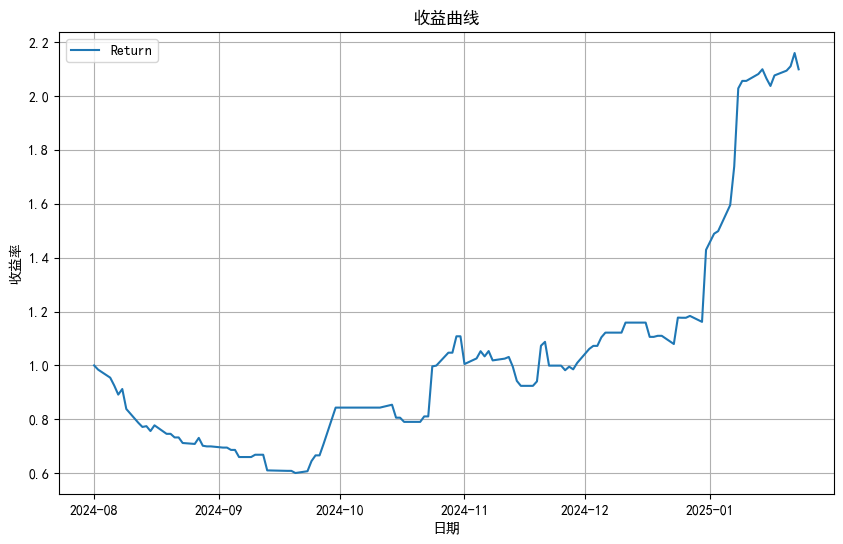

In [94]:
plot(df, 'cumulative_returns')

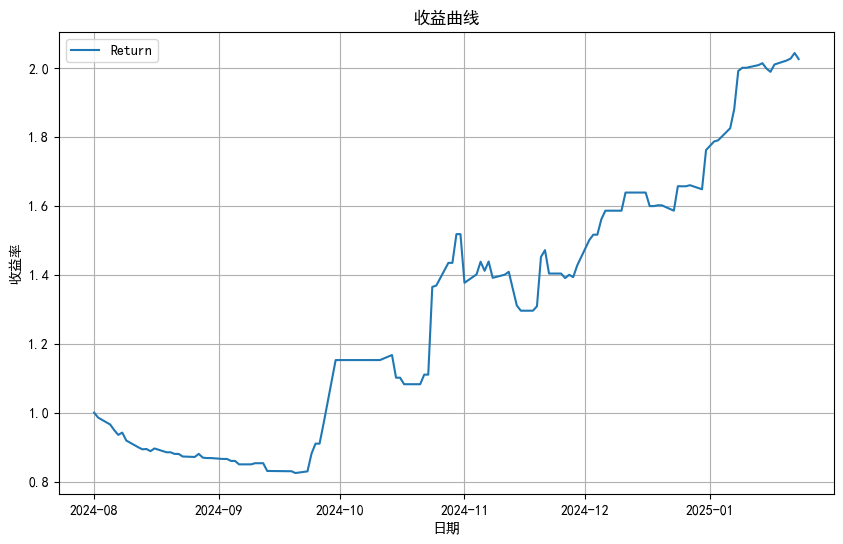

In [95]:
plot(df, 'p_cumulative_returns')

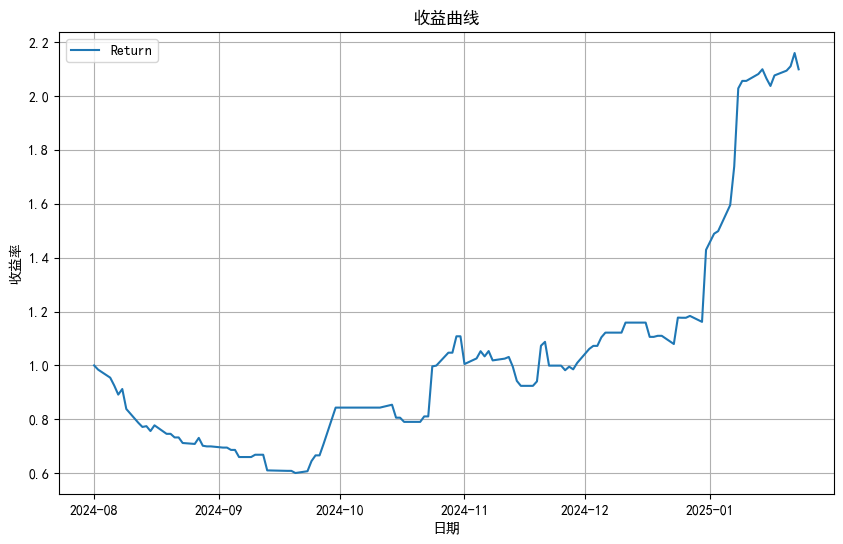

In [96]:
plot(df, 'first_cumulative_returns')

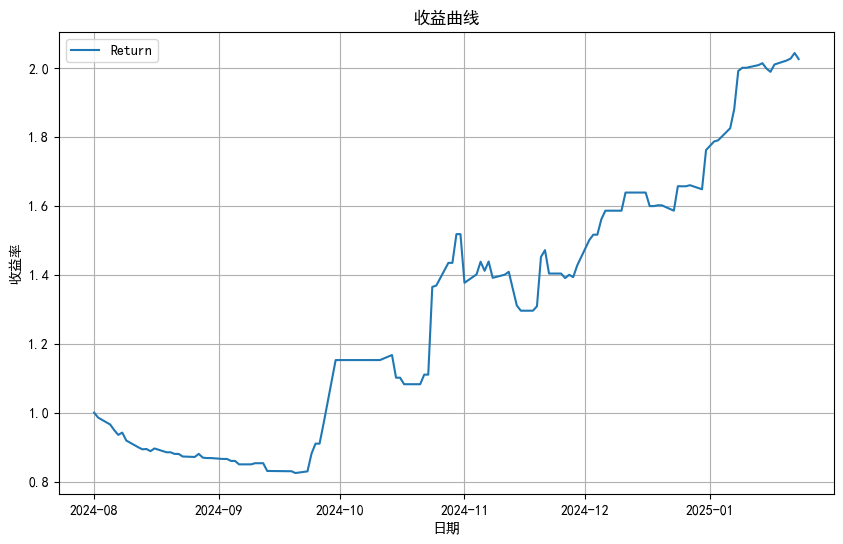

In [97]:
plot(df, 'p_first_cumulative_returns')

In [61]:
len(df_g_zero)

87

In [62]:
len(df)

118

In [63]:
len(df)/len(df_g_zero)

1.3563218390804597

In [99]:
df_after_date = df.loc[df.index >= '2024-10-10']
df_after_date['cumulative_returns'] = (1 + df_after_date['return']).cumprod()
df_after_date['p_return'] = df_after_date['return'] * df_after_date['position']
df_after_date['p_cumulative_returns'] = (1 + df_after_date['p_return']).cumprod()
df_after_date['first_cumulative_returns'] = (1 + df_after_date['first_return']).cumprod()
df_after_date['p_first_return'] = df_after_date['first_return'] * df_after_date['position']
df_after_date['p_first_cumulative_returns'] = (1 + df_after_date['p_first_return']).cumprod()
df_after_date_g_zero = df_after_date[df_after_date['codes_num'] > 0]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_68908\2676662197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_date['cumulative_returns'] = (1 + df_after_date['return']).cumprod()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_68908\2676662197.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_date['p_return'] = df_after_date['return'] * df_after_date['position']
C:\Users\Administrator\AppData\Local\Temp\ipykernel_68908\2676662197.py:4: SettingWithCopyWarning: 
A value is t

In [100]:
print("return:")
print(caculate_returns(df_after_date_g_zero, 'return'))
print("p return:")
print(caculate_returns(df_after_date_g_zero, 'p_return'))
print("first return:")
print(caculate_returns(df_after_date_g_zero, 'first_return'))
print("p first_return:")
print(caculate_returns(df_after_date_g_zero, 'p_first_return'))

return:
{'最大回撤': np.float64(-0.16603417941281293), '夏普比率': np.float64(0.298344298127099), '总收益率': np.float64(1.4895138610879766), '波动率': np.float64(0.06064395198939553), '年化收益率': np.float64(9.70843855887699), '总盈亏': np.float64(1.476815448389564), '成功次数': np.int64(37), '失败次数': np.int64(18), '总天数': np.int64(56), '总交易次数': np.int64(55), '交易频率': np.float64(1.018181818181818), '胜率': np.float64(0.6727272727272727), '平均盈利': np.float64(0.043215117722128424), '平均亏损': np.float64(-0.032542434853927146), '最大盈利': np.float64(0.2300819061801935), '最大亏损': np.float64(-0.0930232558139534), '盈亏比': np.float64(1.3279620260778773), '凯利公式最佳仓位': np.float64(0.42627991892806505)}
p return:
{'最大回撤': np.float64(-0.14629418849239073), '夏普比率': np.float64(0.253901660626751), '总收益率': np.float64(0.75740120955642), '波动率': np.float64(0.04324263963479607), '年化收益率': np.float64(4.936632883715951), '总盈亏': np.float64(0.7447027968580073), '成功次数': np.int64(37), '失败次数': np.int64(18), '总天数': np.int64(56), '总交易次数': np.int64(55), '

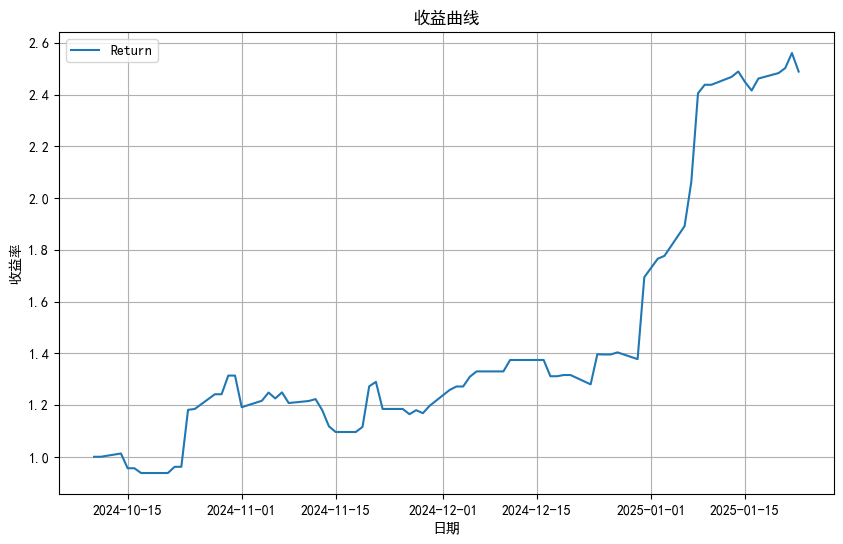

In [101]:
plot(df_after_date, 'cumulative_returns')

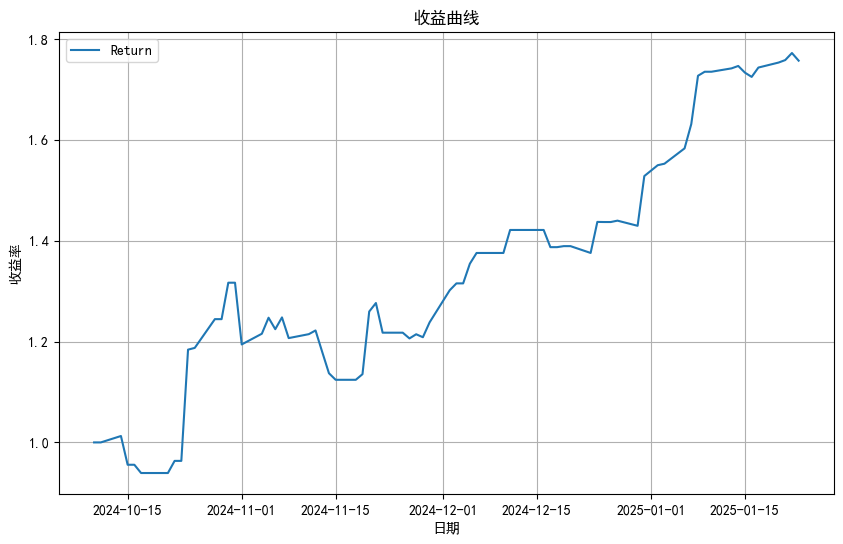

In [102]:
plot(df_after_date, 'p_cumulative_returns')

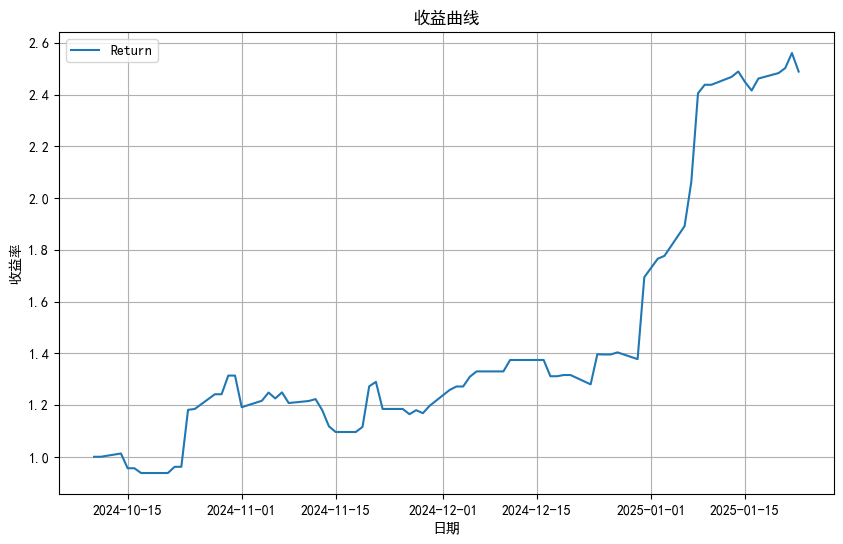

In [103]:
plot(df_after_date, 'first_cumulative_returns')

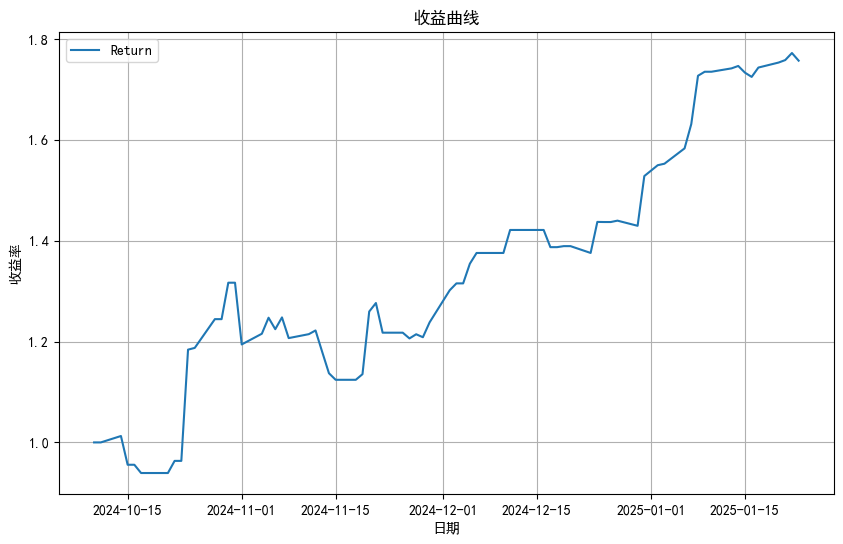

In [104]:
plot(df_after_date, 'p_first_cumulative_returns')

In [105]:
0.008906*0.3

0.0026718

In [28]:
3.61*0.3

1.083

In [29]:
df_g_zero

,code,name,return,max_return,first_return,position,codes_num,cumulative_returns,p_return,p_cumulative_returns,first_cumulative_returns,p_first_return,p_first_cumulative_returns,p3_return,p3_cumulative_returns,p3_first_return,p3_first_cumulative_returns
date,,,,,,,,,,,,,,,,,
2024-07-31,603458.0,low,0.024691,0.024691,0.024691,0.951766,1,1.024691,0.023500,1.023500,1.024691,0.023500,1.023500,0.002469,1.002469,0.003704,1.003704
2024-08-01,600187.0,low,-0.058140,-0.058140,-0.058140,1.000000,1,0.965116,-0.058140,0.963995,0.965116,-0.058140,0.963995,-0.005814,0.996641,-0.008721,0.994950
2024-08-02,603082.0,low,0.033478,0.033478,0.033478,0.927208,1,0.997426,0.031041,0.993918,0.997426,0.031041,0.993918,0.003348,0.999977,0.005022,0.999947
2024-08-05,603988.0,low,0.092593,0.092593,0.092593,0.675140,1,1.089781,0.062513,1.056051,1.089781,0.062513,1.056051,0.009259,1.009236,0.013889,1.013835
2024-08-06,600501.0,low,-0.130841,-0.130841,-0.130841,0.551162,1,0.947193,-0.072115,0.979894,0.947193,-0.072115,0.979894,-0.013084,0.996031,-0.019626,0.993937
2024-08-12,600192.0,low,0.037500,0.037500,0.037500,0.347628,1,0.982712,0.013036,0.992668,0.982712,0.013036,0.992668,0.003750,0.999767,0.005625,0.999528
2024-08-13,597.0,low,-0.054108,-0.054108,-0.054108,0.336042,1,0.929540,-0.018183,0.974619,0.929540,-0.018183,0.974619,-0.005411,0.994357,-0.008116,0.991416
2024-08-15,2717.0,low,0.034091,0.034091,0.034091,0.301886,1,0.961228,0.010292,0.984649,0.961228,0.010292,0.984649,0.003409,0.997747,0.005114,0.996486
2024-08-16,40.0,low,-0.056000,-0.056000,-0.056000,0.316674,1,0.907400,-0.017734,0.967187,0.907400,-0.017734,0.967187,-0.005600,0.992159,-0.008400,0.988115


# 不按凯利公式调仓
## return
- 最大回撤: -20.73%
- 夏普比率: 0.09
- 总收益率: 14.75%
- 波动率: 5.90%
- 最大收益: 16.11%
- 总盈亏: 11.40%
- 成功次数: 19
- 胜率: 51.35%
- 平均盈利: 5.08%
- 平均亏损: -4.25%
- 最大盈利: 16.11%
- 最大亏损: -8.12%
- 盈亏比: 1.20
- 凯利公式最佳仓位: 10.67%

## p return
- 最大回撤: -13.76%
- 夏普比率: 0.19
- 总收益率: 28.26%
- 波动率: 3.91%
- 最大收益: 14.37%
- 总盈亏: 25.16%
- 成功次数: 19
- 胜率: 51.35%
- 平均盈利: 3.46%
- 平均亏损: -2.12%
- 最大盈利: 14.37%
- 最大亏损: -4.99%
- 盈亏比: 1.64
- 凯利公式最佳仓位: 21.61%

## first return
- 最大回撤: -13.93%
- 夏普比率: 0.12
- 总收益率: 23.89%
- 波动率: 5.88%
- 最大收益: 16.11%
- 总盈亏: 20.55%
- 成功次数: 20
- 胜率: 54.05%
- 平均盈利: 4.98%
- 平均亏损: -4.23%
- 最大盈利: 16.11%
- 最大亏损: -9.67%
- 盈亏比: 1.18
- 凯利公式最佳仓位: 15.04%

## p first_return
- 最大回撤: -13.74%
- 夏普比率: 0.20
- 总收益率: 31.27%
- 波动率: 3.85%
- 最大收益: 14.37%
- 总盈亏: 28.17%
- 成功次数: 20
- 胜率: 54.05%
- 平均盈利: 3.30%
- 平均亏损: -2.12%
- 最大盈利: 14.37%
- 最大亏损: -4.99%
- 盈亏比: 1.55
- 凯利公式最佳仓位: 24.50%

## p3 return
- 最大回撤: -6.54%
- 夏普比率: 0.09
- 总收益率: 5.59%
- 波动率: 1.77%
- 最大收益: 4.83%
- 总盈亏: 4.58%
- 成功次数: 19
- 胜率: 51.35%
- 平均盈利: 1.52%
- 平均亏损: -1.27%
- 最大盈利: 4.83%
- 最大亏损: -2.44%
- 盈亏比: 1.20
- 凯利公式最佳仓位: 10.67%

## p3 first return
- 最大回撤: -4.28%
- 夏普比率: 0.12
- 总收益率: 8.05%
- 波动率: 1.76%
- 最大收益: 4.83%
- 总盈亏: 7.04%
- 成功次数: 20
- 胜率: 54.05%
- 平均盈利: 1.50%
- 平均亏损: -1.27%
- 最大盈利: 4.83%
- 最大亏损: -2.90%
- 盈亏比: 1.18
- 凯利公式最佳仓位: 15.04%


<!-- return:
最大回撤: -20.73%
夏普比率: 0.04
总收益率: 1.99%
波动率: 5.35%
最大收益: 10.37%
总盈亏: 5.31%
None
p return:
最大回撤: -7.64%
夏普比率: 0.21
总收益率: 14.38%
波动率: 3.52%
最大收益: 10.37%
总盈亏: 17.71%
None
first return:
最大回撤: -12.83%
夏普比率: 0.13
总收益率: 12.16%
波动率: 5.23%
最大收益: 10.37%
总盈亏: 15.49%
None
p first_return:
最大回撤: -4.61%
夏普比率: 0.26
总收益率: 18.58%
波动率: 3.44%
最大收益: 10.37%
总盈亏: 21.91%
None -->


# 按照凯利公式调仓
## return
- 最大回撤: -20.73%
- 夏普比率: 0.09
- 总收益率: 14.75%
- 波动率: 5.90%
- 最大收益: 16.11%
- 总盈亏: 11.40%
- 成功次数: 19
- 总次数: 37
- 胜率: 51.35%
- 平均盈利: 5.08%
- 平均亏损: -4.25%
- 最大盈利: 16.11%
- 最大亏损: -8.12%
- 盈亏比: 1.20
- 凯利公式最佳仓位: 10.67%

## p return
- 最大回撤: -13.76%
- 夏普比率: 0.19
- 总收益率: 28.26%
- 波动率: 3.91%
- 最大收益: 14.37%
- 总盈亏: 25.16%
- 成功次数: 19
- 总次数: 37
- 胜率: 51.35%
- 平均盈利: 3.46%
- 平均亏损: -2.12%
- 最大盈利: 14.37%
- 最大亏损: -4.99%
- 盈亏比: 1.64
- 凯利公式最佳仓位: 21.61%

## first return
- 最大回撤: -13.93%
- 夏普比率: 0.12
- 总收益率: 23.89%
- 波动率: 5.88%
- 最大收益: 16.11%
- 总盈亏: 20.55%
- 成功次数: 20
- 总次数: 37
- 胜率: 54.05%
- 平均盈利: 4.98%
- 平均亏损: -4.23%
- 最大盈利: 16.11%
- 最大亏损: -9.67%
- 盈亏比: 1.18
- 凯利公式最佳仓位: 15.04%

## p first_return
- 最大回撤: -13.74%
- 夏普比率: 0.20
- 总收益率: 31.27%
- 波动率: 3.85%
- 最大收益: 14.37%
- 总盈亏: 28.17%
- 成功次数: 20
- 总次数: 37
- 胜率: 54.05%
- 平均盈利: 3.30%
- 平均亏损: -2.12%
- 最大盈利: 14.37%
- 最大亏损: -4.99%
- 盈亏比: 1.55
- 凯利公式最佳仓位: 24.50%

## p3 return
- 最大回撤: -2.21%
- 夏普比率: 0.09
- 总收益率: 1.96%
- 波动率: 0.59%
- 最大收益: 1.61%
- 总盈亏: 1.62%
- 成功次数: 19
- 总次数: 37
- 胜率: 51.35%
- 平均盈利: 0.51%
- 平均亏损: -0.42%
- 最大盈利: 1.61%
- 最大亏损: -0.81%
- 盈亏比: 1.20
- 凯利公式最佳仓位: 10.67%

## p3 first return
- 最大回撤: -2.15%
- 夏普比率: 0.12
- 总收益率: 4.10%
- 波动率: 0.88%
- 最大收益: 2.42%
- 总盈亏: 3.59%
- 成功次数: 20
- 总次数: 37
- 胜率: 54.05%
- 平均盈利: 0.75%
- 平均亏损: -0.63%
- 最大盈利: 2.42%
- 最大亏损: -1.45%
- 盈亏比: 1.18
- 凯利公式最佳仓位: 15.04%


# 10月15号后
## return
- 最大回撤: -20.73%
- 夏普比率: 0.04
- 总收益率: 1.99%
- 波动率: 5.35%
- 最大收益: 10.37%
- 总盈亏: 5.31%
- 成功次数: 10
- 总次数: 19
- 胜率: 52.63%
- 平均盈利: 4.50%
- 平均亏损: -4.48%
- 最大盈利: 10.37%
- 最大亏损: -8.12%
- 盈亏比: 1.00
- 凯利公式最佳仓位: 5.48%

## p return
- 最大回撤: -7.64%
- 夏普比率: 0.21
- 总收益率: 14.38%
- 波动率: 3.52%
- 最大收益: 10.37%
- 总盈亏: 17.71%
- 成功次数: 10
- 总次数: 19
- 胜率: 52.63%
- 平均盈利: 3.30%
- 平均亏损: -2.04%
- 最大盈利: 10.37%
- 最大亏损: -4.61%
- 盈亏比: 1.62
- 凯利公式最佳仓位: 23.34%

## first return
- 最大回撤: -12.83%
- 夏普比率: 0.13
- 总收益率: 12.16%
- 波动率: 5.23%
- 最大收益: 10.37%
- 总盈亏: 15.49%
- 成功次数: 11
- 总次数: 19
- 胜率: 57.89%
- 平均盈利: 4.49%
- 平均亏损: -4.41%
- 最大盈利: 10.37%
- 最大亏损: -8.12%
- 盈亏比: 1.02
- 凯利公式最佳仓位: 16.54%

## p first_return
- 最大回撤: -4.61%
- 夏普比率: 0.26
- 总收益率: 18.58%
- 波动率: 3.44%
- 最大收益: 10.37%
- 总盈亏: 21.91%
- 成功次数: 11
- 总次数: 19
- 胜率: 57.89%
- 平均盈利: 3.13%
- 平均亏损: -2.03%
- 最大盈利: 10.37%
- 最大亏损: -4.61%
- 盈亏比: 1.54
- 凯利公式最佳仓位: 30.60%
